In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

START = 2022
END = 2025

In [2]:
# RAG+LLM 추출 내용 load
def get_extracted_data(start : int = START, end : int = END, root : str = "res_peft"):
    papers = {}
    models = {}

    for i in range(start, end+1):
        papers[f"{i}"] = pd.read_csv(f"./{root}/{i}/papers.csv")
        models[f"{i}"] = pd.read_csv(f"./{root}/{i}/models.csv")

    return papers, models

papers, models = get_extracted_data()


# LoRA 관련 논문에서의 파라미터 변화 추이 시각화

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def visualize_parameter_distribution_by_year(models, normalize=False, use_log=True, plot_type='box'):
    """
    연도별 모델 파라미터 수의 분포를 시각화하는 함수 (Boxplot + Strip plot)
    
    Args:
        models (dict): {year: dataframe} 형태의 데이터
        normalize (bool): 전체 데이터 기준 Min-Max 정규화 수행 여부
        use_log (bool): Y축 로그 스케일 적용 여부 (분포 확인 시 권장)
        plot_type (str): 'box', 'violin', 'boxen' 중 선택
    """
    
    df_list = []
    for year, df in models.items():
        temp_df = df.copy()
        temp_df['year'] = int(year)
        df_list.append(temp_df)
    
    combined_df = pd.concat(df_list, ignore_index=True)

    y_col = 'backbone_parameter_count'
    y_label = 'Parameter Count'
    
    if normalize:
        min_val = combined_df[y_col].min()
        max_val = combined_df[y_col].max()
        combined_df['display_value'] = (combined_df[y_col] - min_val) / (max_val - min_val)
        y_label = 'Normalized Scale (0 to 1)'
    else:
        combined_df['display_value'] = combined_df[y_col]

    plt.figure(figsize=(14, 8))
    sns.set_style("whitegrid")
    
    palette = sns.color_palette("viridis", n_colors=len(combined_df['year'].unique()))

    if plot_type == 'violin':
        sns.violinplot(data=combined_df, x='year', y='display_value', inner=None, color=".9")
    elif plot_type == 'boxen':
        sns.boxenplot(data=combined_df, x='year', y='display_value', palette=palette)
    else: # default: box
        sns.boxplot(data=combined_df, x='year', y='display_value', 
                    palette=palette, width=0.6, showfliers=False,
                    boxprops=dict(alpha=0.6))

    sns.stripplot(data=combined_df, x='year', y='display_value', 
                  color="black", size=5, alpha=0.4, jitter=True)

    if use_log and not normalize:
        plt.yscale("log")
        y_label += ' (Log Scale)'
    
    title_kind = "Normalized" if normalize else "Raw"
    plt.title(f'{title_kind} Parameter Size Distribution by Year', fontsize=18, pad=20)
    plt.xlabel('Year', fontsize=13)
    plt.ylabel(y_label, fontsize=13)
    
    summary_text = "Box: Interquartile Range (IQR)\nLine: Median\nDots: Individual Models"
    plt.annotate(summary_text, xy=(0.02, 0.90), xycoords='axes fraction', 
                 fontsize=10, bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8))
    
    plt.tight_layout()
    plt.show()


In [4]:
models[str(2023)].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   paper_id                   151 non-null    object 
 1   model_id                   151 non-null    int64  
 2   model_name                 151 non-null    object 
 3   backbone_model_name        136 non-null    object 
 4   task                       151 non-null    object 
 5   backbone_parameter_count   130 non-null    float64
 6   backbone_parameter_unit    130 non-null    object 
 7   learnable_parameter_count  81 non-null     float64
 8   learnable_parameter_unit   81 non-null     object 
 9   learnable_parameter_ratio  79 non-null     float64
 10  notes                      39 non-null     object 
dtypes: float64(3), int64(1), object(7)
memory usage: 13.1+ KB


In [ ]:
def unify_unit_to_million(df):
    """
    backbone_parameter_unit이 'B'인 데이터를 찾아 
    숫자값에 1,000을 곱하고 단위를 'M'으로 통일합니다.
    """
    df_clean = df.copy()
    
    mask_b = df_clean['backbone_parameter_unit'].str.upper() == 'B'
    
    df_clean.loc[mask_b, 'backbone_parameter_count'] *= 1000
    
    df_clean.loc[mask_b, 'backbone_parameter_unit'] = 'M'
    
    return df_clean


for i in range(START, END+1):
    models[str(i)] = unify_unit_to_million(models[str(i)])

/var/folders/1n/3_46_bbx39l4m34jz8q8xbmr0000gn/T/ipykernel_12601/1015878197.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df, x='year', y='display_value',


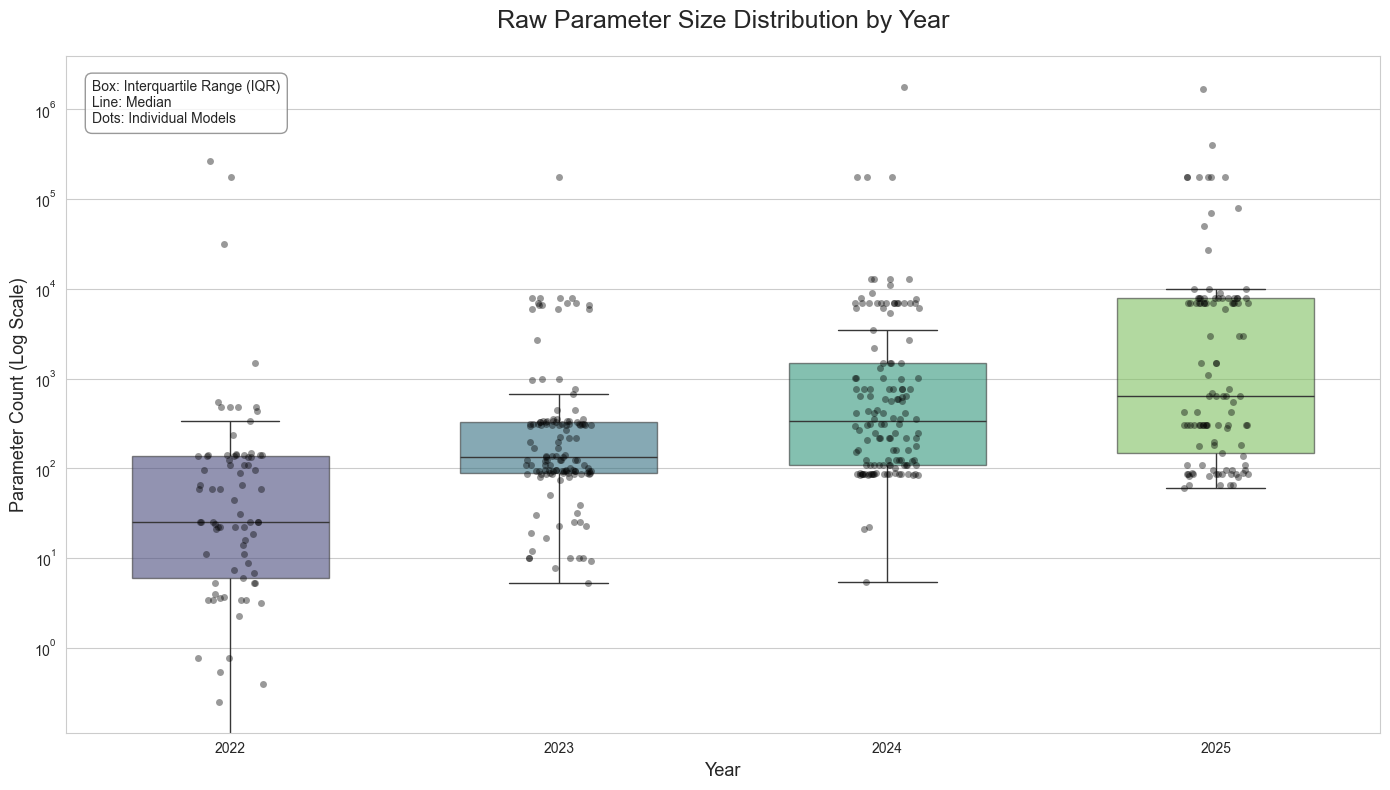

In [6]:
visualize_parameter_distribution_by_year(models, use_log=True)

/var/folders/1n/3_46_bbx39l4m34jz8q8xbmr0000gn/T/ipykernel_12601/1015878197.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=combined_df, x='year', y='display_value', palette=palette)


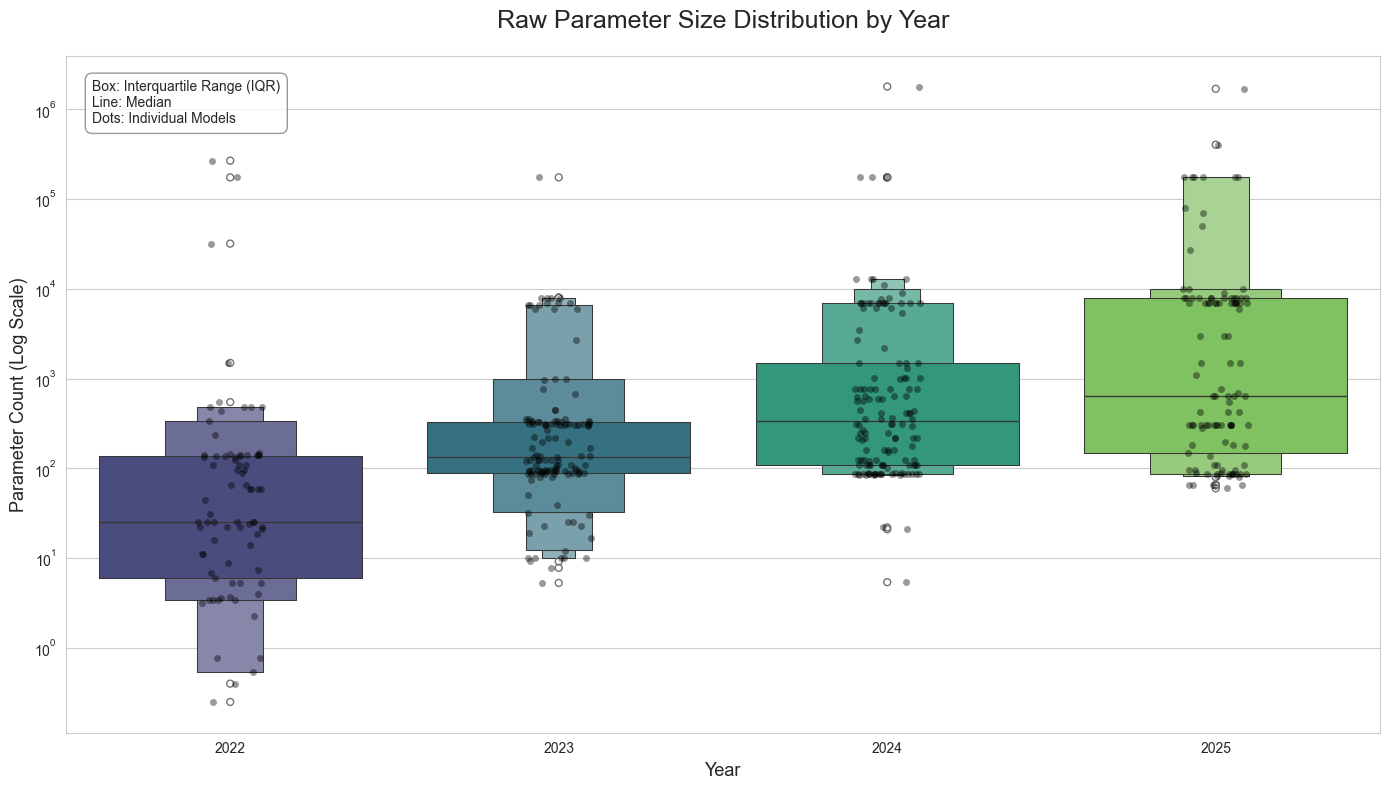

In [7]:
visualize_parameter_distribution_by_year(models, use_log=True, plot_type="boxen")

/var/folders/1n/3_46_bbx39l4m34jz8q8xbmr0000gn/T/ipykernel_12601/315245878.py:34: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(data=plot_df, x='year', y='learnable_parameter_count',
/var/folders/1n/3_46_bbx39l4m34jz8q8xbmr0000gn/T/ipykernel_12601/315245878.py:34: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  sns.pointplot(data=plot_df, x='year', y='learnable_parameter_count',
/var/folders/1n/3_46_bbx39l4m34jz8q8xbmr0000gn/T/ipykernel_12601/315245878.py:45: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(data=plot_df, x='year', y='leverage_rat

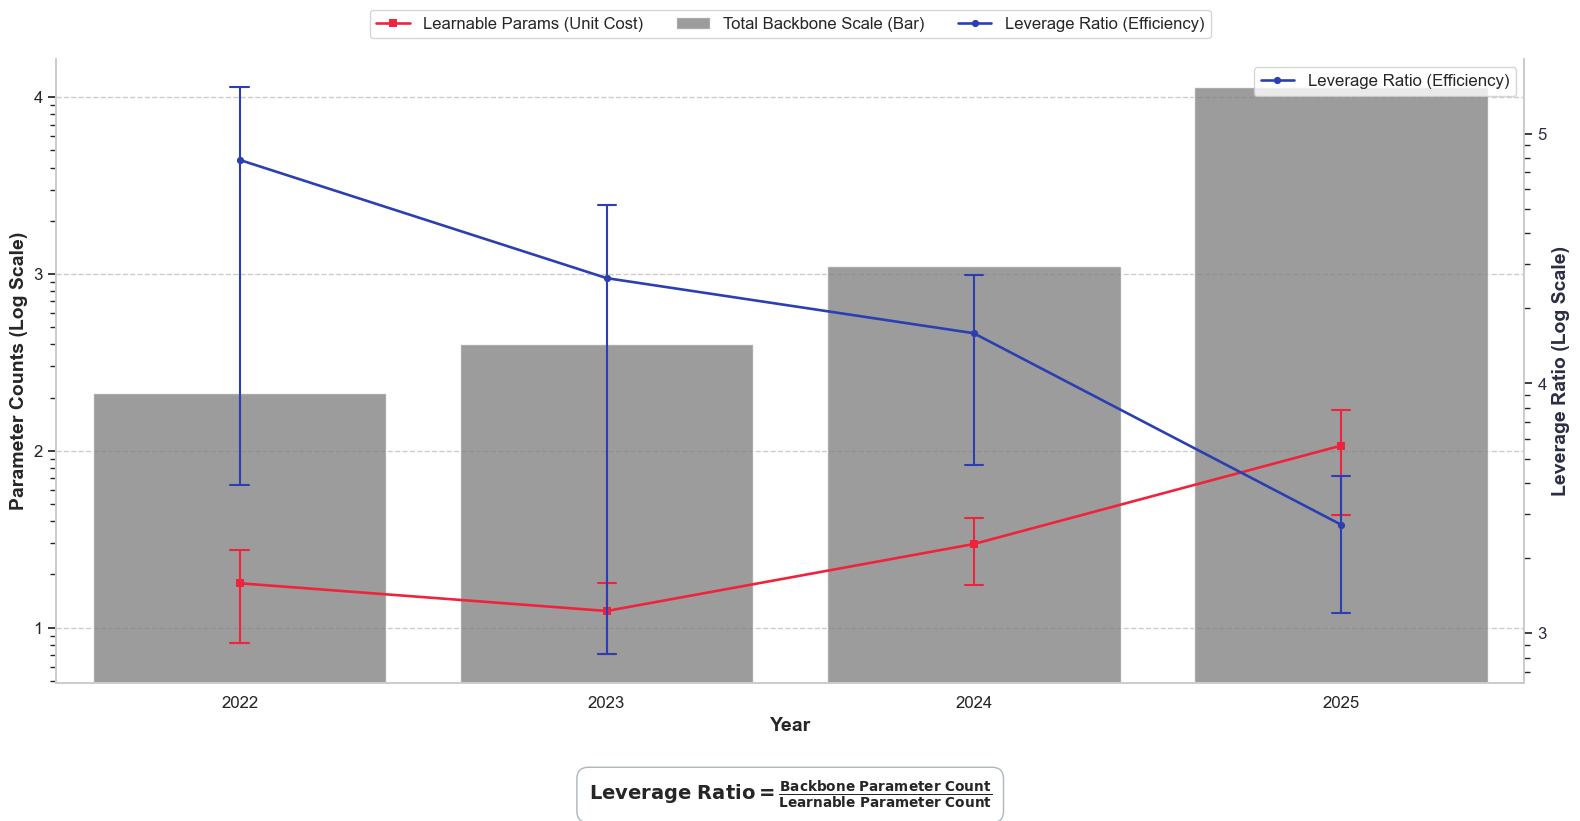

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def visualize_jevons_final_report_v3(models):
    df_list = []
    for year, df in models.items():
        temp_df = df.copy()
        temp_df['year'] = str(year)
        df_list.append(temp_df)
    
    combined_df = pd.concat(df_list, ignore_index=True)

    plot_df = combined_df.dropna(subset=['backbone_parameter_count', 'learnable_parameter_count']).copy()
    plot_df['leverage_ratio'] = plot_df['backbone_parameter_count'] / plot_df['learnable_parameter_count']
    plot_df = plot_df.sort_values('year')

    sns.set_context("notebook", font_scale=1.1)
    sns.set_style("whitegrid", {'grid.linestyle': '--', 'grid.alpha': 0.3})
    
    fig, ax1 = plt.subplots(figsize=(16, 10))

    sns.barplot(data=plot_df, x='year', y='backbone_parameter_count', 
                ax=ax1, color="#838383", alpha=0.8, errorbar=None, 
                label='Total Backbone Scale (Bar)', zorder=1)
    
    sns.pointplot(data=plot_df, x='year', y='learnable_parameter_count', 
                  ax=ax1, color='#EF233C', markers="s", scale=0.7, 
                  errorbar=('se', 1), capsize=0.05, errwidth=1.5,
                  label='Learnable Params (Unit Cost)', zorder=3)

    ax1.set_yscale("log")
    ax1.set_ylabel('Parameter Counts (Log Scale)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Year', fontsize=14, fontweight='bold')

    ax2 = ax1.twinx()
    sns.pointplot(data=plot_df, x='year', y='leverage_ratio', 
                  ax=ax2, color="#2B3FB2", markers="o", scale=0.7,
                  errorbar=('se', 1), capsize=0.05, errwidth=1.5,
                  label='Leverage Ratio (Efficiency)', zorder=4)

    ax2.set_yscale("log")
    ax2.set_ylabel('Leverage Ratio (Log Scale)', fontsize=14, fontweight='bold', color='#2B2D42')
    ax2.tick_params(axis='y', labelcolor='#2B2D42')
    ax2.grid(False)

    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    
    ax1.legend(handles1 + handles2, labels1 + labels2, 
               loc='lower center', bbox_to_anchor=(0.5, 1.02), 
               ncol=3, frameon=True, shadow=False, fontsize=12)

    formula_text = r"$\bf{Leverage\ Ratio} = \frac{Backbone\ Parameter\ Count}{Learnable\ Parameter\ Count}$"
    ax1.text(0.5, -0.18, formula_text, ha='center', va='center', transform=ax1.transAxes,
             fontsize=14, fontweight='bold',
             bbox=dict(boxstyle="round,pad=0.6", fc="white", ec="#ADB5BD", alpha=1.0, zorder=5))

    ax1.yaxis.set_major_formatter(ticker.LogFormatterExponent(base=10))
    ax2.yaxis.set_major_formatter(ticker.LogFormatterExponent(base=10))

    sns.despine(right=False)
    plt.tight_layout(rect=[0, 0.08, 1, 0.95]) 
    plt.show()


visualize_jevons_final_report_v3(models)

In [9]:
task_envMentioned_anual = {}

for i in range(START, END+1):
    task_envMentioned_anual[str(i)] = pd.merge(papers[str(i)], models[str(i)], on="paper_id").drop_duplicates(subset=["paper_id"])[["task", "environment_mentioned"]]

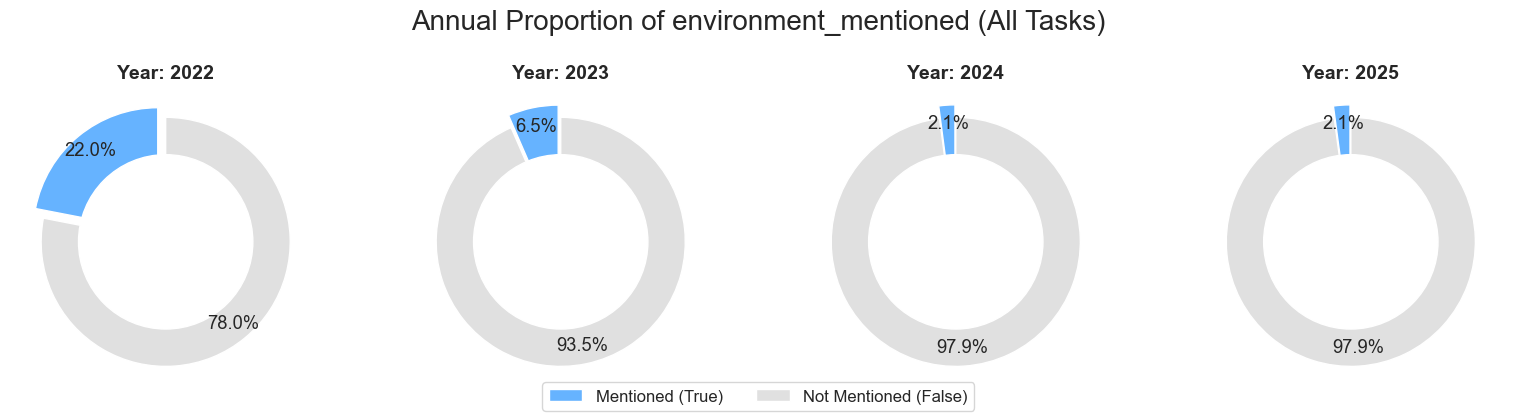

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import math

def plot_mentioned_ratio_pie(data_dict, tag : str):
    """
    연도별 전체 데이터에서 mentioned가 차지하는 비율을 원형 차트로 시각화
    """
    years = sorted(data_dict.keys())
    num_years = len(years)
    
    cols = 4
    rows = math.ceil(num_years / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(16, 4 * rows))
    axes = axes.flatten() # 2차원 배열을 1차원으로 변환하여 반복문 사용 용이하게 함

    colors = ['#ff9999', '#66b3ff'] # False, True 순서
    
    for i, year in enumerate(years):
        df = data_dict[year]
        

        counts = df[tag].value_counts().sort_index() # False(0), True(1) 순 정렬
        

        labels = [f"Mentioned ({counts.get(True, 0)})", f"Not Mentioned ({counts.get(False, 0)})"]
        sizes = [counts.get(True, 0), counts.get(False, 0)]
        

        axes[i].pie(
            sizes, 
            labels=None, # 범례가 따로 있으므로 라벨은 제거
            autopct='%1.1f%%', # 퍼센트 표시
            startangle=90, 
            colors=['#66b3ff', '#e0e0e0'], # True(파랑), False(회색)
            pctdistance=0.85,
            explode=(0.1, 0) if counts.get(True, 0) > 0 else (0, 0) # 언급된 부분 살짝 분리
        )
        

        centre_circle = plt.Circle((0,0), 0.70, fc='white')
        axes[i].add_artist(centre_circle)
        
        axes[i].set_title(f"Year: {year}", fontsize=14, fontweight='bold')

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.figlegend(['Mentioned (True)', 'Not Mentioned (False)'], loc='lower center', ncol=2, fontsize=12)
    
    plt.suptitle(f'Annual Proportion of {tag} (All Tasks)', fontsize=20, y=1.02)
    plt.tight_layout()
    plt.show()

    
plot_mentioned_ratio_pie(task_envMentioned_anual, "environment_mentioned")

# LoRA관련 논문 MeraData에서 abstract로 토픽 모델링 해보기

In [ ]:
import re
from pathlib import Path
from typing import List
import os


def extract_abstracts_from_folder(md_dir: str) -> List[str]:
    """
    특정 폴더 내 markdown 파일들에서 Abstract를 추출하여 list[str]로 반환한다.

    지원 시작 형식:
      - ## Abstract
      - # Abstract
      - Abstract
      - Abstract-This paper ...
      - Abstract -This paper ...
      - Abstract - This paper ...
      - Abstract: This paper ...

    종료 규칙:
      - abstract 내용 이후 첫 번째 빈 줄 (\\n\\n)
    """

    md_dir = Path(md_dir)
    abstracts: List[str] = []
    start_pattern = re.compile(
        r"(?:^|\n)"                 # 문서 처음 or 줄 시작
        r"(?:#+\s*)?"               # optional markdown header
        r"abstract"                 # Abstract
        r"(?:\s*[-–—:]\s*|\s+)"     # -, —, :, 혹은 공백
        r"*",
        re.IGNORECASE,
    )

    for md_file in md_dir.glob("*.md"):
        text = md_file.read_text(encoding="utf-8", errors="ignore")

        match = start_pattern.search(text)
        if not match:
            continue

        start_idx = match.end()
        rest = text[start_idx:]

        end_match = re.search(r"\n\s*\n", rest)
        if end_match:
            end_idx = start_idx + end_match.start()
        else:
            end_idx = len(text)

        abstract_text = text[start_idx:end_idx].strip()

        if abstract_text:
            abstracts.append(abstract_text)

    return abstracts


def get_peft_abstracts(start : int = START, end : int = END):
    abstracts_anual = {}

    for i in range(start, end+1):
        abstracts_anual[str(i)] = extract_abstracts_from_folder(
            f"./res_peft/{i}/markdown"
        )

    return abstracts_anual


In [12]:
abstracts_anual = get_peft_abstracts()

In [13]:
import nltk
import spacy
from nltk.corpus import stopwords


nltk.download("stopwords")
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])


STOPWORDS = set(stopwords.words("english"))
CUSTOM_STOPWORDS = {
    "method", "methods", "approach", "approaches",
    "result", "results", "show", "shows", "showing",
    "paper", "study", "studies", "propose", "proposed",
    "based", "using", "use", "used",
    "model", "models", "task", "training", "cloud", "parameter", "efficient", "pre", "fine", "tune", "high", "base", "significantly",
    "tuning", "however", "learning", "train", "learn", "performance", "acheive",
    "lora", "adapt", "adapter", "peft", "pet"
}

STOPWORDS |= CUSTOM_STOPWORDS


def preprocess_abstracts(abstracts: List[str], batch_size: int = 1000) -> List[str]:

    results = []

    for doc in nlp.pipe(abstracts, batch_size=batch_size, n_process=-1,):
        tokens = []
        for token in doc:
            if not token.is_alpha: continue

            lemma = token.lemma_.lower()

            if len(lemma) <= 2: continue
            if lemma in STOPWORDS: continue

            tokens.append(lemma)
        results.append(" ".join(tokens))

    return results

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yunsehyeog/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
for i in range(START, END+1):
    abstracts_anual[str(i)] = preprocess_abstracts(abstracts_anual[str(i)])

In [ ]:
import math
import networkx as nx
import matplotlib.pyplot as plt
from bertopic import BERTopic
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer


def get_default_model():
    """분석에 사용할 기본 BERTopic 모델 아키텍처 정의"""
    return BERTopic(
        nr_topics=10,
        language="english",
        hdbscan_model=HDBSCAN(
            min_cluster_size=20,
            min_samples=15,
            prediction_data=True
        )
    )


def prepare_data_from_dict(abstracts_dict: dict[str, list[str]]):
    """딕셔너리 데이터를 분석용 리스트와 타임스탬프로 정제"""
    all_docs = []
    all_years = []
    
    for year in range(START, END + 1):
        year_key = str(year)
        if year_key in abstracts_dict:
            unique_docs = list(set(abstracts_dict[year_key]))
            all_docs.extend(unique_docs)
            all_years.extend([year_key] * len(unique_docs))
            
    return all_docs, all_years


def run_keyword_network_analysis_by_year(abstracts_dict: dict[str, list[str]], max_features=20, top_n_edges=30):
    """연도별 키워드 공존 관계를 그리드 형태로 시각화하여 트렌드 변화 추적"""
    years = sorted([y for y in abstracts_dict.keys() if START <= int(y) <= END])
    num_years = len(years)
    
    cols = 2
    rows = math.ceil(num_years / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 7 * rows))
    axes = axes.flatten() if num_years > 1 else [axes]
    
    for i, year in enumerate(years):
        ax = axes[i]
        docs = list(set(abstracts_dict[year]))
        
        if not docs or len(docs) < 2:
            ax.set_title(f"Year: {year} (Insufficient Data)")
            ax.axis('off')
            continue

        cv = CountVectorizer(max_features=max_features)
        try:
            word_matrix = cv.fit_transform(docs)
            full_labels = {j: word for j, word in enumerate(cv.get_feature_names_out())}
        except:
            ax.axis('off')
            continue
            
        adj_matrix = (word_matrix.T * word_matrix)
        adj_matrix.setdiag(0)
        
        G = nx.from_scipy_sparse_array(adj_matrix)
        
        all_edges = sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)
        G_filtered = nx.Graph()
        G_filtered.add_nodes_from(G.nodes(data=True))
        G_filtered.add_edges_from(all_edges[:top_n_edges])
        G_filtered.remove_nodes_from(list(nx.isolates(G_filtered)))

        if len(G_filtered.nodes()) == 0:
            ax.set_title(f"Year: {year} (No Strong Connections)")
            ax.axis('off')
            continue

        current_labels = {n: full_labels[n] for n in G_filtered.nodes()}
        
        pos = nx.spring_layout(G_filtered, k=1.3, seed=42)
        degrees = dict(G_filtered.degree)
        
        nx.draw_networkx_nodes(G_filtered, pos, ax=ax, node_size=[v * 250 for v in degrees.values()], 
                               node_color='skyblue', edgecolors='white', alpha=0.8)
        nx.draw_networkx_labels(G_filtered, pos, ax=ax, labels=current_labels, font_size=10, font_weight='bold')
        
        weights = [d['weight'] for u, v, d in G_filtered.edges(data=True)]
        max_w = max(weights) if weights else 1
        nx.draw_networkx_edges(G_filtered, pos, ax=ax, width=[(w / max_w) * 4 for w in weights], 
                               edge_color='gray', alpha=0.3)
        
        ax.set_title(f"Year: {year} (Keywords Connection)", fontsize=14)
        ax.axis('off')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle(f"Evolution of Research Keywords ({START}-{END})", fontsize=20, y=1.02)
    plt.tight_layout()
    plt.show()

/Users/yunsehyeog/Desktop/대학교/01_비교과/01_2025데이터톤/00_code/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


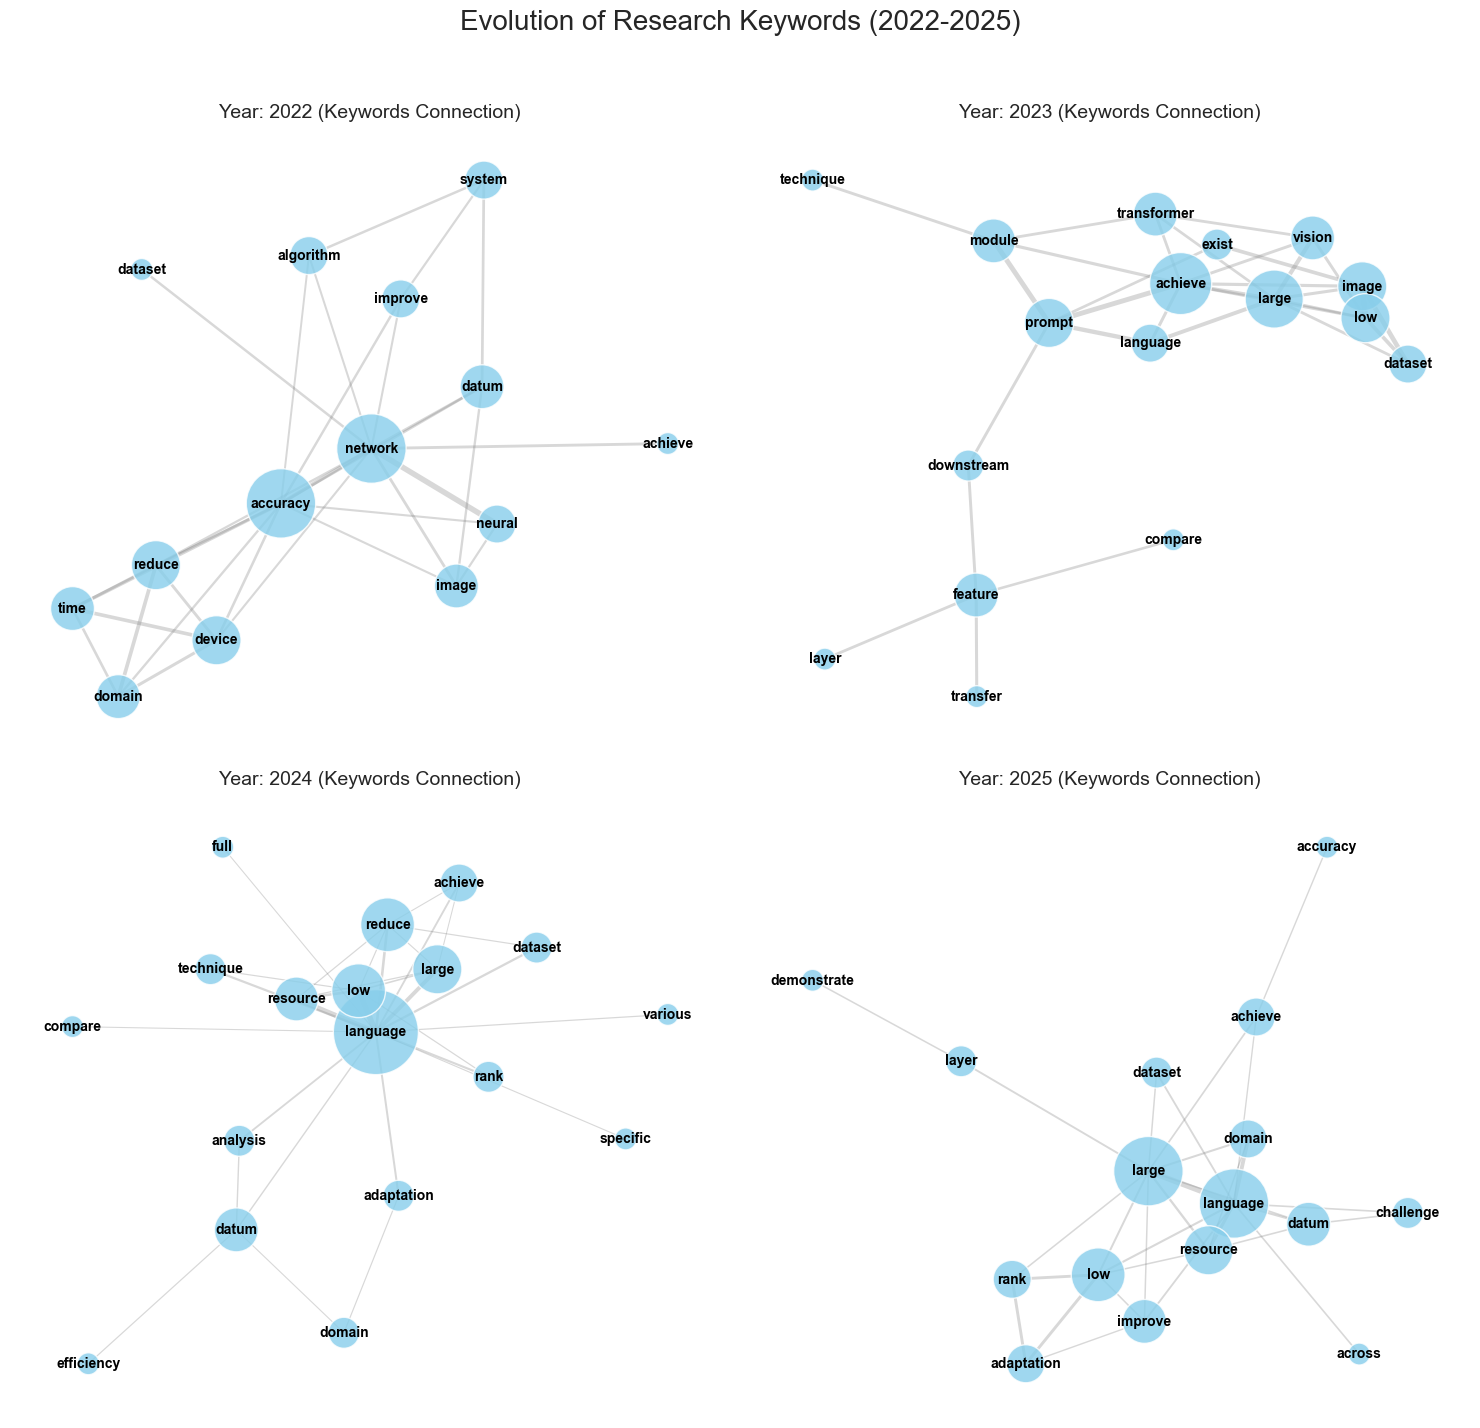

In [ ]:
run_keyword_network_analysis_by_year(abstracts_anual, max_features=20, top_n_edges=30)